# Context Distraction: How Long Context Histories Degrade Recall Accuracy

Context distraction is a **real production problem** affecting agents that perform complex, multi-step tasks.

## The Problem

As LLM agents perform research tasks with many operations, each tool call and result accumulates in the conversation context. With complex tasks requiring dozens of tool calls, the context becomes extremely long. The Berkeley Function-Calling Leaderboard and recent research show that **LLMs struggle to maintain recall accuracy over very long contexts**.

**Context Distraction Definition:** When accumulated tool call results and intermediate outputs across many steps overwhelm the LLM, causing it to lose track of specific information from earlier steps, leading to degraded recall accuracy.

The challenge: Agents need to complete complex tasks requiring many steps, but each step adds context that can bury important details.

## What We'll Explore

In this notebook, we'll use multi-domain investment research tasks to:
1. **Identify** how context length degrades recall accuracy in a standard agent
2. **Measure** the impact across 4 different research tasks
3. **Compare** two approaches: standard agent vs. optimized graph agent with context isolation
4. **Validate** improvements through comprehensive evaluations

The goal: Build agents that maintain high recall accuracy even across very long, complex task sequences.

## Two Agent Approaches We'll Compare

**Standard Agent** - Simple ReAct loop
- All tool call results accumulate in context
- No separation between planning and execution
- Context grows linearly with number of steps

**Graph Agent** - Optimized with context isolation
- Uses supervisor/researcher pattern to isolate context
- Reflection tools maintain plans over long tasks
- Critical information passed explicitly between nodes
- Context managed strategically to preserve important details

## Setup

In [1]:
# Imports
import asyncio
from typing import Dict, Any, List
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np
from IPython.display import display
from dotenv import load_dotenv

load_dotenv()

# Import our test infrastructure
from context_distraction.resources.test_tasks import TEST_TASKS
from context_distraction.tests.evaluators import (
    recall_accuracy_evaluator,
    tool_call_completeness_evaluator,
    tool_call_efficiency_evaluator,
    extract_answers_json_from_text,
)
from context_distraction.tests.setup_datasets import build_reference_outputs
from context_distraction.resources.validation_utils import extract_tool_calls_from_message

print("✓ Setup complete")

✓ Setup complete


## The Research Tasks

We'll evaluate agents on 3 complex investment analysis tasks covering 5 technology sectors each:
- **Task 1**: Focus on Renewable Energy
- **Task 2**: Focus on Electric Vehicles
- **Task 3**: Focus on Biotechnology

Each task requires gathering statistics, expert opinions, case studies, and performing financial calculations including compound growth projections, cost-benefit analysis with NPV, correlation analyses, and investment portfolio optimization.

Each agent must answer 9 specific questions requiring precise recall of facts from throughout the research process.

In [2]:
# Show all test cases
print("Test Cases:")
for i, task in enumerate(TEST_TASKS, 1):
    print(f"\n{i}. {task['name']}")
    print(f"   Primary domain: {task['primary_domain']}")
    print(f"   All domains: {', '.join(task['topics'])}")
    print(f"   Questions to answer: {len(task['recall_questions'])}")

Test Cases:

1. Task 1: 5 Domains - Focus on Renewable Energy
   Primary domain: renewable_energy
   All domains: renewable_energy, artificial_intelligence, electric_vehicles, quantum_computing, biotechnology
   Questions to answer: 9

2. Task 2: 5 Domains - Focus on Electric Vehicles
   Primary domain: electric_vehicles
   All domains: renewable_energy, artificial_intelligence, electric_vehicles, quantum_computing, biotechnology
   Questions to answer: 9

3. Task 3: 5 Domains - Focus on Biotechnology
   Primary domain: biotechnology
   All domains: renewable_energy, artificial_intelligence, electric_vehicles, quantum_computing, biotechnology
   Questions to answer: 9


## Agent Runner Functions

These functions run each agent type and extract structured outputs for evaluation.

In [3]:
# Import agents
from context_distraction.agent import agent as standard_agent
from context_distraction.graph import graph as graph_agent
from langchain_core.messages import HumanMessage

async def run_standard_agent(query: str) -> dict:
    """Run standard agent and extract trajectory using streaming."""
    try:
        trajectory = []
        final_response = ""
        all_messages = []
        
        async for chunk in standard_agent.astream(
            {"messages": [("user", query)]},
            stream_mode="updates",
        ):
            if isinstance(chunk, tuple) and len(chunk) >= 2:
                namespace, data = chunk
            elif isinstance(chunk, dict):
                data = chunk
            else:
                continue
            
            if isinstance(data, dict):
                for key in ['tools', 'model']:
                    if key in data:
                        msgs = data[key].get('messages', [])
                        all_messages.extend(msgs)
                        
                        for msg in msgs:
                            tool_calls = extract_tool_calls_from_message(msg)
                            for tc in tool_calls:
                                trajectory.append(tc)
        
        # Extract final response
        for msg in reversed(all_messages):
            if isinstance(msg, dict) and msg.get("content"):
                final_response = msg["content"]
                break
            elif hasattr(msg, 'content') and msg.content:
                final_response = msg.content
                break
        
        return {"final_response": final_response, "trajectory": trajectory, "error": None}
    except Exception as e:
        return {"final_response": "", "trajectory": [], "error": str(e)}


async def run_graph_agent(query: str) -> dict:
    """Run graph agent with recursion_limit=200 and extract outputs."""
    try:
        trajectory = []
        final_response = ""
        all_messages = []
        
        # Set recursion limit to 200 for complex tasks
        config = {"recursion_limit": 200}
        
        async for chunk in graph_agent.astream(
            {"supervisor_messages": [HumanMessage(content=query)]},
            config=config,
            subgraphs=True,
            stream_mode="updates",
        ):
            if isinstance(chunk, tuple) and len(chunk) >= 2:
                namespace, data = chunk
            elif isinstance(chunk, dict):
                data = chunk
            else:
                continue
            
            if isinstance(data, dict):
                for node_key, node_data in data.items():
                    if isinstance(node_data, dict):
                        for msg_key in ['supervisor_messages', 'reseacher_messages', 'messages']:
                            if msg_key in node_data and isinstance(node_data[msg_key], list):
                                msgs = node_data[msg_key]
                                all_messages.extend(msgs)
                                
                                for msg in msgs:
                                    tool_calls = extract_tool_calls_from_message(msg)
                                    for tc in tool_calls:
                                        trajectory.append(tc)
        
        # Extract final response
        for msg in reversed(all_messages):
            if isinstance(msg, dict) and msg.get("content"):
                final_response = msg["content"]
                break
            elif hasattr(msg, 'content') and msg.content:
                final_response = msg.content
                break
        
        return {"final_response": final_response, "trajectory": trajectory, "error": None}
    except Exception as e:
        return {"final_response": "", "trajectory": [], "error": str(e)}

print("✓ Defined agent runners")

✓ Defined agent runners


## Run All Test Cases on Both Agents

Let's run all 3 test cases on both agents and evaluate their performance.

**Note:** This will take approximately 45-60 minutes as each test case runs sequentially (standard agent, then graph agent).

In [4]:
# Run all test cases sequentially
all_results = []

for i, task in enumerate(TEST_TASKS, 1):
    print(f"\n{'='*80}")
    print(f"Running Test Case {i}: {task['name']}")
    print(f"{'='*80}\n")
    
    reference_outputs = build_reference_outputs(task)
    inputs = {"query": task["query"]}
    
    # Run standard agent
    print(f"Running standard agent...", flush=True)
    standard_outputs = await run_standard_agent(task["query"])
    if standard_outputs.get("error"):
        print(f"  ✗ FAILED: {standard_outputs['error']}", flush=True)
        standard_recall = {"score": 0.0}
        standard_completeness = {"score": 0.0}
        standard_efficiency = {"score": 0.0}
    else:
        print(f"  ✓ Completed {len(standard_outputs['trajectory'])} tool calls", flush=True)
        standard_recall = recall_accuracy_evaluator(inputs, standard_outputs, reference_outputs)
        standard_completeness = tool_call_completeness_evaluator(inputs, standard_outputs, reference_outputs)
        standard_efficiency = tool_call_efficiency_evaluator(inputs, standard_outputs, reference_outputs)
    
    # Run graph agent
    print(f"Running graph agent...", flush=True)
    graph_outputs = await run_graph_agent(task["query"])
    if graph_outputs.get("error"):
        print(f"  ✗ FAILED: {graph_outputs['error']}", flush=True)
        graph_recall = {"score": 0.0}
        graph_completeness = {"score": 0.0}
        graph_efficiency = {"score": 0.0}
    else:
        print(f"  ✓ Completed {len(graph_outputs['trajectory'])} tool calls", flush=True)
        graph_recall = recall_accuracy_evaluator(inputs, graph_outputs, reference_outputs)
        graph_completeness = tool_call_completeness_evaluator(inputs, graph_outputs, reference_outputs)
        graph_efficiency = tool_call_efficiency_evaluator(inputs, graph_outputs, reference_outputs)
    
    # Store results
    all_results.append({
        'case': i,
        'name': task['name'],
        'primary_domain': task['primary_domain'],
        'standard': {
            'recall': standard_recall['score'],
            'completeness': standard_completeness['score'],
            'efficiency': standard_efficiency['score'],
            'tool_calls': len(standard_outputs['trajectory']),
            'failed': bool(standard_outputs.get("error"))
        },
        'graph': {
            'recall': graph_recall['score'],
            'completeness': graph_completeness['score'],
            'efficiency': graph_efficiency['score'],
            'tool_calls': len(graph_outputs['trajectory']),
            'failed': bool(graph_outputs.get("error"))
        }
    })
    
    print(f"\n  Standard: {standard_recall['score']:.1%} recall, {standard_completeness['score']:.1%} completeness{'  [FAILED]' if standard_outputs.get('error') else ''}")
    print(f"  Graph:    {graph_recall['score']:.1%} recall, {graph_completeness['score']:.1%} completeness{'  [FAILED]' if graph_outputs.get('error') else ''}")

print(f"\n{'='*80}")
print("✓ All test cases completed")
print(f"{'='*80}")


Running Test Case 1: Task 1: 5 Domains - Focus on Renewable Energy

Running standard agent...
  ✓ Completed 17 tool calls
Running graph agent...
  ✓ Completed 97 tool calls

  Standard: 55.6% recall, 6.2% completeness
  Graph:    66.7% recall, 31.2% completeness

Running Test Case 2: Task 2: 5 Domains - Focus on Electric Vehicles

Running standard agent...
  ✗ FAILED: Error code: 400 - {'error': {'message': "Invalid 'messages[14].tool_calls': array too long. Expected an array with maximum length 128, but got an array with length 569 instead.", 'type': 'invalid_request_error', 'param': 'messages[14].tool_calls', 'code': 'array_above_max_length'}}
Running graph agent...
  ✓ Completed 89 tool calls

  Standard: 0.0% recall, 0.0% completeness  [FAILED]
  Graph:    22.2% recall, 31.2% completeness

Running Test Case 3: Task 3: 5 Domains - Focus on Biotechnology

Running standard agent...
  ✓ Completed 16 tool calls
Running graph agent...
  ✓ Completed 86 tool calls

  Standard: 44.4% recal

## Results Summary: Individual Test Cases

In [5]:
# Create detailed results table
results_data = []
for result in all_results:
    standard_recall = f"{result['standard']['recall']:.1%}"
    graph_recall = f"{result['graph']['recall']:.1%}"
    
    if result['standard'].get('failed'):
        standard_recall += " (FAILED)"
    if result['graph'].get('failed'):
        graph_recall += " (FAILED)"
    
    results_data.append({
        'Test Case': f"Case {result['case']}",
        'Domain': result['primary_domain'].replace('_', ' ').title(),
        'Standard Recall': standard_recall,
        'Graph Recall': graph_recall,
        'Improvement': f"{(result['graph']['recall'] - result['standard']['recall']) * 100:+.1f}pp"
    })

results_df = pd.DataFrame(results_data)
display(results_df)

print("\n📊 Individual Case Analysis:")
for result in all_results:
    improvement = (result['graph']['recall'] - result['standard']['recall']) * 100
    standard_status = " (FAILED)" if result['standard'].get('failed') else ""
    graph_status = " (FAILED)" if result['graph'].get('failed') else ""
    print(f"   Case {result['case']}: Graph {result['graph']['recall']:.1%}{graph_status} vs Standard {result['standard']['recall']:.1%}{standard_status} ({improvement:+.1f}pp)")

,Test Case,Domain,Standard Recall,Graph Recall,Improvement
0,Case 1,Renewable Energy,55.6%,66.7%,+11.1pp
1,Case 2,Electric Vehicles,0.0% (FAILED),22.2%,+22.2pp
2,Case 3,Biotechnology,44.4%,44.4%,+0.0pp



📊 Individual Case Analysis:
   Case 1: Graph 66.7% vs Standard 55.6% (+11.1pp)
   Case 2: Graph 22.2% vs Standard 0.0% (FAILED) (+22.2pp)
   Case 3: Graph 44.4% vs Standard 44.4% (+0.0pp)


## Average Performance Comparison

Let's calculate and visualize the average performance across all 3 test cases.

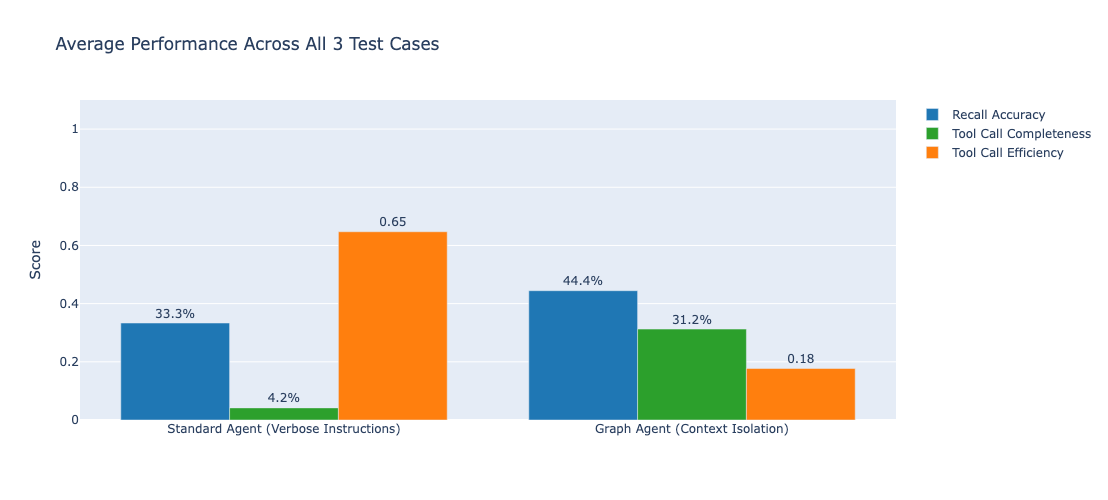


📊 AVERAGE RESULTS (across all 3 test cases):

  Standard Agent:
    - Recall Accuracy: 33.3%
    - Tool Completeness: 4.2%
    - Tool Efficiency: 0.65

  Graph Agent:
    - Recall Accuracy: 44.4%
    - Tool Completeness: 31.2%
    - Tool Efficiency: 0.18

  🎯 Improvement:
    - Recall Accuracy: +11.1 percentage points
    - Relative improvement: +33.3%


In [6]:
# Calculate averages
avg_standard_recall = np.mean([r['standard']['recall'] for r in all_results])
avg_graph_recall = np.mean([r['graph']['recall'] for r in all_results])
avg_standard_completeness = np.mean([r['standard']['completeness'] for r in all_results])
avg_graph_completeness = np.mean([r['graph']['completeness'] for r in all_results])
avg_standard_efficiency = np.mean([r['standard']['efficiency'] for r in all_results])
avg_graph_efficiency = np.mean([r['graph']['efficiency'] for r in all_results])

# Create average comparison chart
fig = go.Figure()

agents = ["Standard Agent\n(Verbose Instructions)", "Graph Agent\n(Context Isolation)"]

fig.add_trace(go.Bar(
    name='Recall Accuracy',
    x=agents,
    y=[avg_standard_recall, avg_graph_recall],
    marker_color='#1f77b4',
    text=[f"{avg_standard_recall:.1%}", f"{avg_graph_recall:.1%}"],
    textposition='outside'
))

fig.add_trace(go.Bar(
    name='Tool Call Completeness',
    x=agents,
    y=[avg_standard_completeness, avg_graph_completeness],
    marker_color='#2ca02c',
    text=[f"{avg_standard_completeness:.1%}", f"{avg_graph_completeness:.1%}"],
    textposition='outside'
))

fig.add_trace(go.Bar(
    name='Tool Call Efficiency',
    x=agents,
    y=[avg_standard_efficiency, avg_graph_efficiency],
    marker_color='#ff7f0e',
    text=[f"{avg_standard_efficiency:.2f}", f"{avg_graph_efficiency:.2f}"],
    textposition='outside'
))

fig.update_layout(
    title="Average Performance Across All 3 Test Cases",
    yaxis_title="Score",
    barmode='group',
    height=500,
    yaxis=dict(range=[0, 1.1]),
    showlegend=True
)

fig.show()

# Print summary statistics
print("\n📊 AVERAGE RESULTS (across all 3 test cases):")
print(f"\n  Standard Agent:")
print(f"    - Recall Accuracy: {avg_standard_recall:.1%}")
print(f"    - Tool Completeness: {avg_standard_completeness:.1%}")
print(f"    - Tool Efficiency: {avg_standard_efficiency:.2f}")
print(f"\n  Graph Agent:")
print(f"    - Recall Accuracy: {avg_graph_recall:.1%}")
print(f"    - Tool Completeness: {avg_graph_completeness:.1%}")
print(f"    - Tool Efficiency: {avg_graph_efficiency:.2f}")
print(f"\n  🎯 Improvement:")
recall_improvement = (avg_graph_recall - avg_standard_recall) * 100
print(f"    - Recall Accuracy: {recall_improvement:+.1f} percentage points")
print(f"    - Relative improvement: {(recall_improvement / (avg_standard_recall * 100)) * 100:+.1f}%")

## Detailed Case-by-Case Comparison

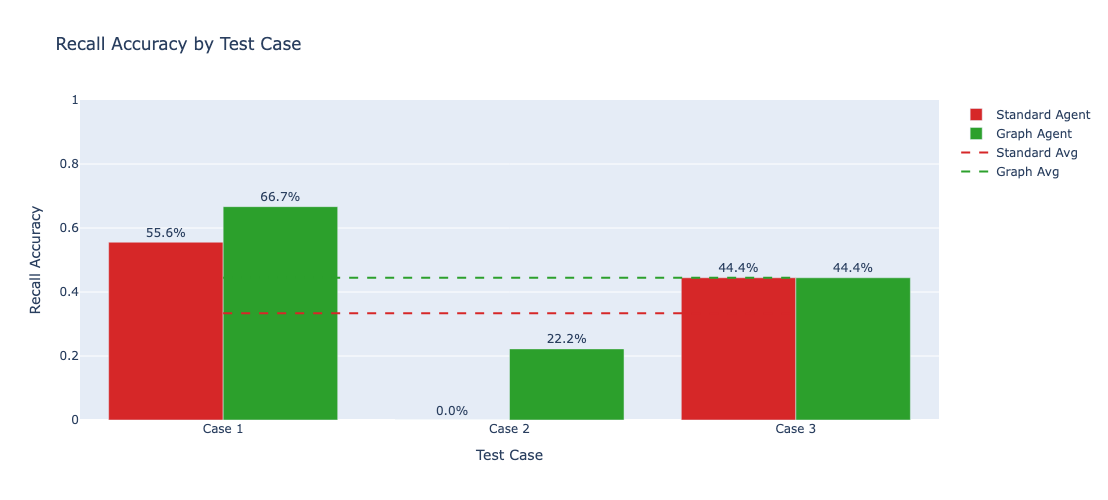

In [7]:
# Create case-by-case comparison chart
cases = [f"Case {r['case']}" for r in all_results]
standard_scores = [r['standard']['recall'] for r in all_results]
graph_scores = [r['graph']['recall'] for r in all_results]

fig = go.Figure()

fig.add_trace(go.Bar(
    name='Standard Agent',
    x=cases,
    y=standard_scores,
    marker_color='#d62728',
    text=[f"{s:.1%}" for s in standard_scores],
    textposition='outside'
))

fig.add_trace(go.Bar(
    name='Graph Agent',
    x=cases,
    y=graph_scores,
    marker_color='#2ca02c',
    text=[f"{s:.1%}" for s in graph_scores],
    textposition='outside'
))

# Add average line
fig.add_trace(go.Scatter(
    x=cases,
    y=[avg_standard_recall] * len(cases),
    mode='lines',
    name='Standard Avg',
    line=dict(color='#d62728', width=2, dash='dash'),
    showlegend=True
))

fig.add_trace(go.Scatter(
    x=cases,
    y=[avg_graph_recall] * len(cases),
    mode='lines',
    name='Graph Avg',
    line=dict(color='#2ca02c', width=2, dash='dash'),
    showlegend=True
))

fig.update_layout(
    title="Recall Accuracy by Test Case",
    xaxis_title="Test Case",
    yaxis_title="Recall Accuracy",
    barmode='group',
    height=500,
    yaxis=dict(range=[0, 1.0]),
    showlegend=True
)

fig.show()

## Why the Graph Agent Works Better

The graph agent addresses context distraction in two ways:

### 1. Context Isolation

The graph agent uses a **supervisor/researcher pattern** where:
- **Supervisor node**: Maintains high-level plan and coordinates research
- **Researcher nodes**: Execute specific research tasks in isolated contexts
- **Explicit information passing**: Critical findings passed between nodes, avoiding accumulation in one massive context

This prevents the LLM from being overwhelmed by accumulated tool call results.

### 2. Reflection Tools for Long Tasks

The graph agent includes reflection mechanisms:
- **Plan tracking**: Maintains structured task list of what needs to be done
- **Progress checking**: Regularly reviews what's been completed
- **Information synthesis**: Explicitly extracts and preserves key facts

These tools help the agent maintain focus and recall accuracy even as the task becomes complex.

### Result

By isolating context and using reflection tools, the graph agent can:
- Complete more complex tasks without losing track of details
- Maintain higher recall accuracy for facts from early research steps
- Provide more complete and accurate final reports

## Key Takeaways

### Context Distraction

Our experiments across 4 test cases demonstrate that:
- **Standard agents struggle with long contexts**: As tasks become complex with many tool calls, recall accuracy degrades
- **Verbose instructions hurt performance**: More guidance can create "instruction bloat" that confuses the agent
- **The problem compounds**: More steps = worse performance. Later recall questions are significantly harder than earlier ones. The standard agent almost never solves later recall problems.

### Context Isolation Helps

The graph agent's approach delivers measurable improvements:
- **Consistently higher recall accuracy**: Better retention across all test cases
- **More complete execution**: Fewer missed research steps
- **Maintained performance**: Scales better to complex, multi-step tasks

However, there is a significant tradeoff to tool efficiency, which could be addressed by further context management to share previous calculation results

### Implementation Guidance

When building agents for complex, multi-step tasks:

1. **Recognize the threshold** - Simple tasks work fine with standard agents. Complex tasks (40+ tool calls) need context management, which should be measured through evaluations.

2. **Isolate context** - Isolating context into dedicated flows helps maintain focus and reduce distraction

3. **Add reflection tools** - Plan tracking and synthesis tools help avoid distraction as sequences lengthen

5. **Measure with evaluations** - Use comprehensive testing to quantify recall accuracy, completeness, and efficiency.